### Imports

In [ ]:
!rm -rf qber-forecasting
!rm -rf deep_qber
!git clone https://github.com/rmnigm/qber-forecasting.git
!cp -r qber-forecasting/deep_qber deep_qber

In [ ]:
!pip install catboost
!pip install pytorch_lightning

In [3]:
import os
import random
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score

import catboost
from catboost import Pool, CatBoostRegressor, CatBoostClassifier

In [4]:
from deep_qber.utils import OutlierDetector

### Feature Extraction

In [5]:
def get_features_df(dataframe, look_back=5, train_size=0.75):
    dataset = dataframe.values
    columns = list(dataframe.columns)
    train_size = int(len(dataset) * train_size)
    test_size = len(dataset) - train_size
    data_train, data_test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    print(f"Training set size = {train_size}, testing set size = {test_size}")

    length = data_train.shape[0]
    width = data_train.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    train_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            train_df[feature_name] = x[look_back:, lag, i]

    length = data_test.shape[0]
    width = data_test.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    test_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            test_df[feature_name] = x[look_back:, lag, i]

    return train_df, test_df

In [6]:
pulses_stats_file_path = "/content/qber-forecasting/datasets/data.csv"
dataframe = pd.read_csv(pulses_stats_file_path,
                        usecols=range(1, 8),
                        engine='python',
                        )
# dataframe = dataframe[0:100000]
dataset = dataframe.values.astype('float32')

In [7]:
outl = OutlierDetector(window_size=100, alpha=6)
no_outliers = outl.fit_transform(dataframe['e_mu_current'].values)


outliers = np.array(no_outliers) != dataframe['e_mu_current'].values
dataframe['outliers'] = outliers.astype(int)

print()
print(f'Total = {outliers.sum()}')
print(f'Frequency = {outliers.mean()}')

100%|██████████| 184750/184750 [00:51<00:00, 3570.57it/s]


Total = 591
Frequency = 0.0031971869083040304


In [8]:
train_size = 0.75
look_back = 4
target_index = 0
x_train, x_test = get_features_df(dataframe, train_size=train_size, look_back=look_back)

Training set size = 138637, testing set size = 46213


### Model Training and Inference

In [9]:
drop_cols = ['e_mu_current_0_lag'] + [f'outliers_{k}_lag' for k in range(5)]
target_col_name = 'outliers_0_lag'

train_pool = Pool(x_train.drop(columns=drop_cols), x_train[target_col_name])
test_pool = Pool(x_test.drop(columns=drop_cols), x_test[target_col_name])

In [ ]:
model = CatBoostClassifier()

model.fit(train_pool, eval_set=test_pool)
preds = model.predict(test_pool)

In [12]:
for metric in (f1_score, accuracy_score, roc_auc_score, recall_score, precision_score):
    print(f'{metric.__name__} value:')
    print(f'{metric(preds, x_test[target_col_name]):.3f}')

f1_score value:
1.000
accuracy_score value:
1.000
roc_auc_score value:
1.000
recall_score value:
1.000
precision_score value:
1.000


In [13]:
plotting_data = {
    'predicted': preds,
    'actual': x_test[target_col_name],
    'value': x_test['e_mu_current_0_lag']
    }

plotting_data = pd.DataFrame(plotting_data).reset_index()
plotting_data['missed'] = plotting_data['predicted'] != plotting_data['actual']

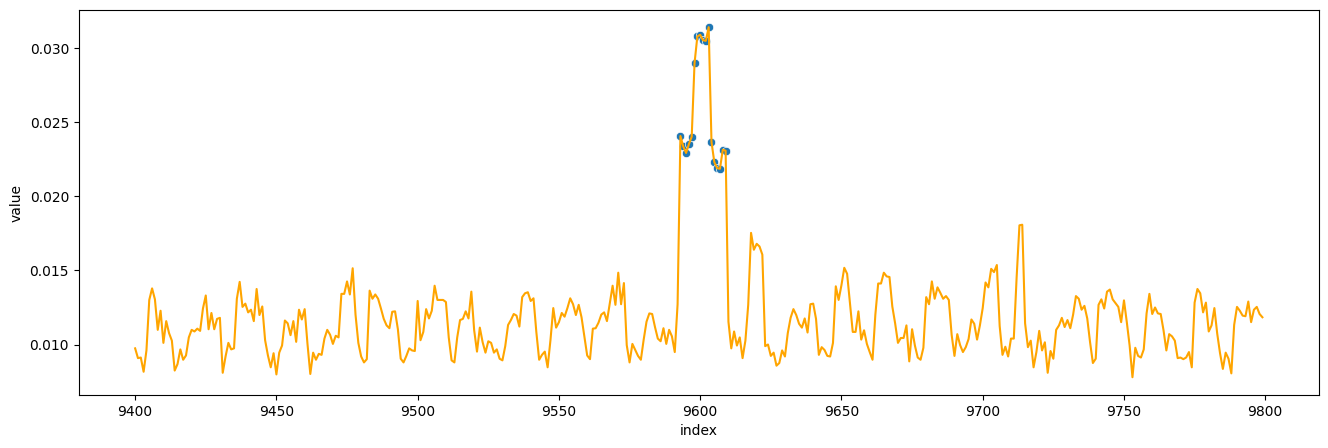

In [19]:
df = plotting_data[9400:9800]
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df, x='index', y='value', ax=ax, color='orange')
sns.scatterplot(data=df[df['actual']==1], x='index', y='value', ax=ax)
plt.show()

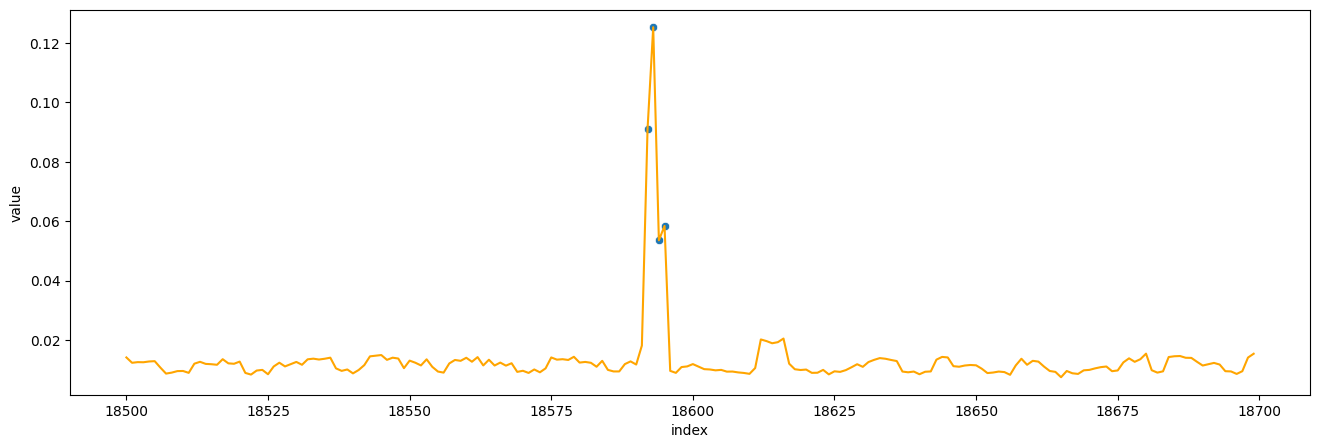

In [14]:
df = plotting_data[18500:18700]
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df, x='index', y='value', ax=ax, color='orange')
sns.scatterplot(data=df[df['actual']==1], x='index', y='value', ax=ax)
plt.show()

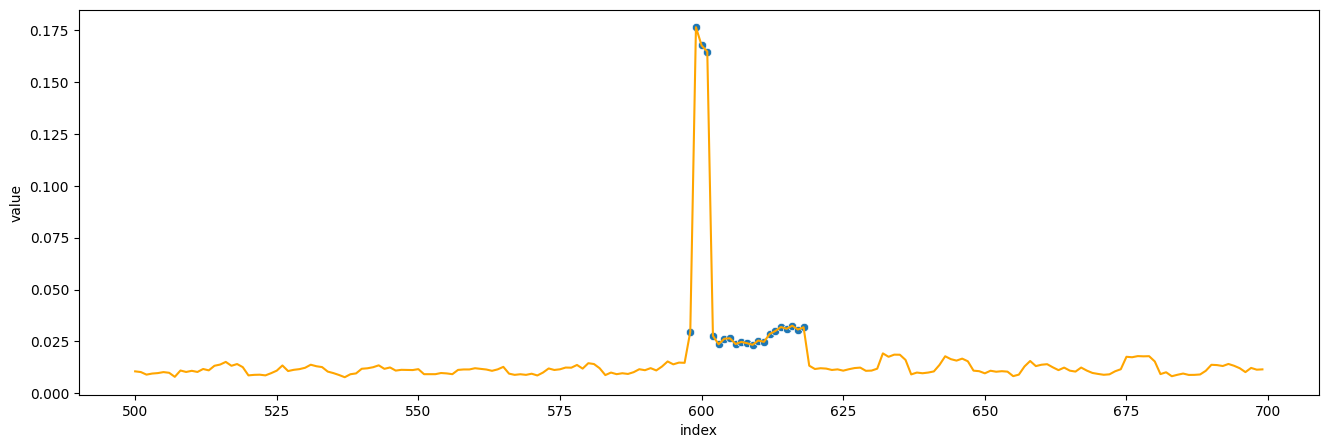

In [15]:
df = plotting_data[500:700]
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df, x='index', y='value', ax=ax, color='orange')
sns.scatterplot(data=df[df['actual']==1], x='index', y='value', ax=ax)
plt.show()

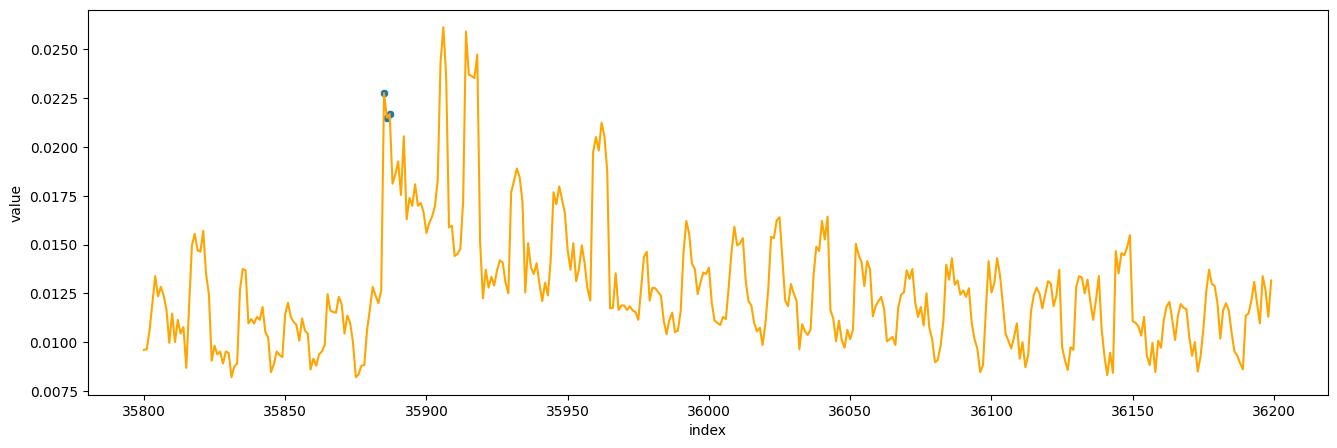

In [24]:
df = plotting_data[35800:36200]
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df, x='index', y='value', ax=ax, color='orange')
sns.scatterplot(data=df[df['actual']==1], x='index', y='value', ax=ax)
plt.show()

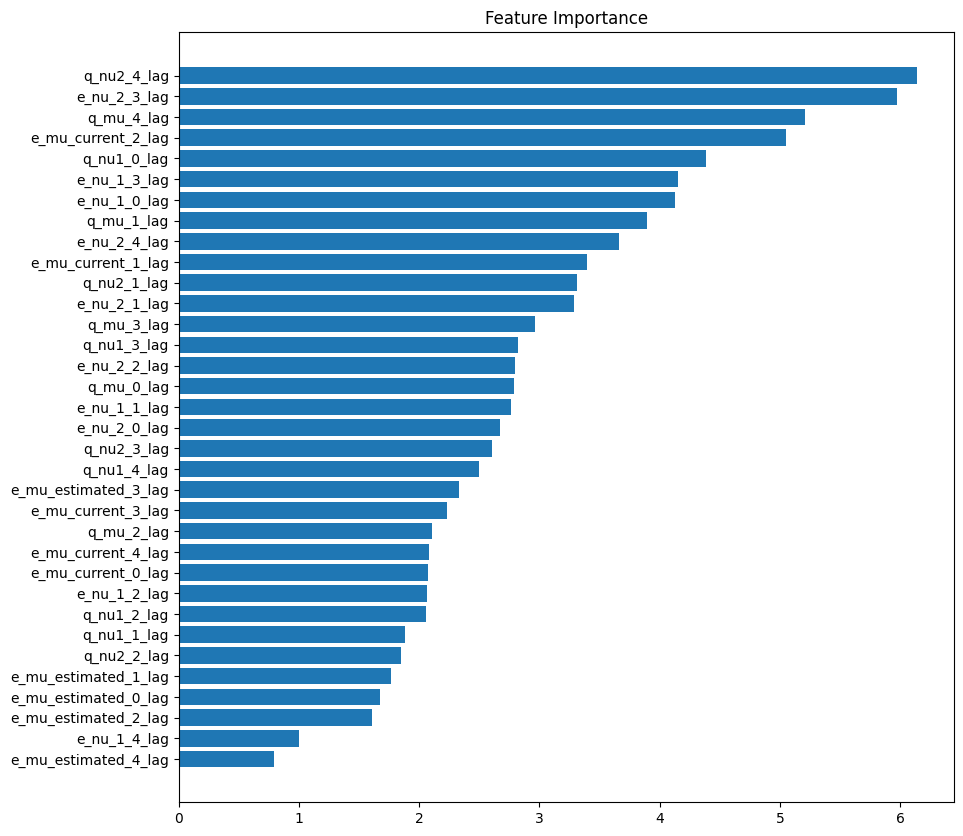

In [22]:
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

### Other outlier labelling methods

In [44]:
from collections import deque
import statistics


def fit(ts):
    data = []
    big_window = deque(ts[:100])
    small_window = deque(ts[80:100])
    for i in tqdm(range(len(ts[100:]))):
        item = ts[i]
        big_med = statistics.median(big_window)
        small_med = statistics.median(small_window)
        big_std = statistics.stdev(big_window)
        small_std = statistics.stdev(small_window)
        big_diff = np.abs(item - big_med)
        small_diff = np.abs(item - small_med)
        data.append((big_med, big_std, big_diff, small_med, small_std, small_diff))
        big_window.append(item)
        small_window.append(item)
        big_window.popleft()
        small_window.popleft()
    return data

In [45]:
data = fit(ts=dataframe['e_mu_current'].values)

100%|██████████| 184750/184750 [01:04<00:00, 2862.36it/s]


In [46]:
big_med, big_std, big_diff, small_med, small_std, small_diff = zip(*data)

In [47]:
df = pd.DataFrame({
    'big_med': big_med,
    'big_std': big_std,
    'big_diff': big_diff,
    'small_med': small_med,
    'small_std': small_std,
    'small_diff': small_diff,
}).reset_index()

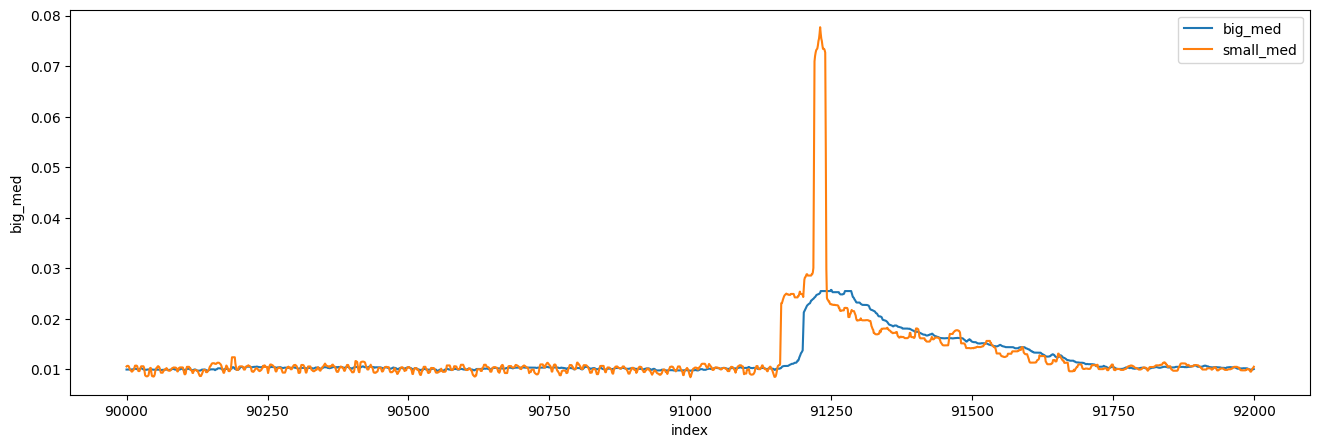

In [48]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df[90000:92000], x='index', y='big_med', ax=ax, label='big_med')
sns.lineplot(data=df[90000:92000], x='index', y='small_med', ax=ax, label='small_med')
plt.show()

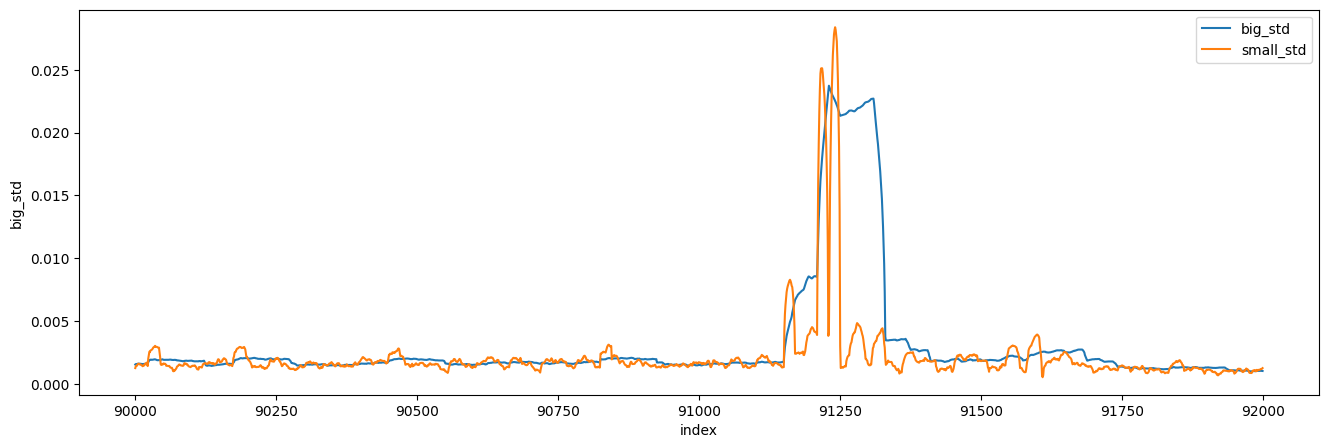

In [49]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df[90000:92000], x='index', y='big_std', ax=ax, label='big_std')
sns.lineplot(data=df[90000:92000], x='index', y='small_std', ax=ax, label='small_std')
plt.show()

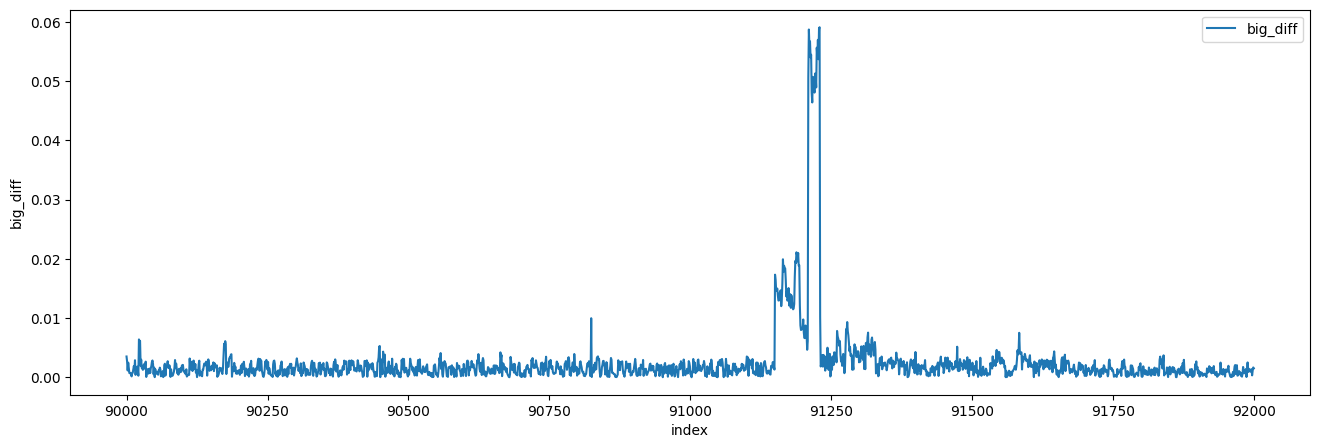

In [51]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df[90000:92000], x='index', y='big_diff', ax=ax, label='big_diff')
plt.show()

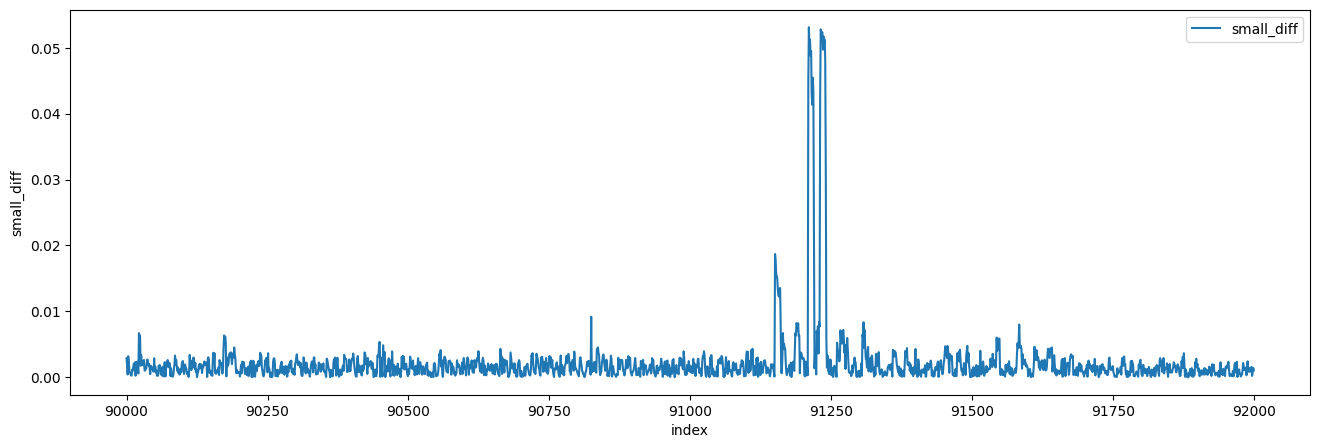

In [52]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=df[90000:92000], x='index', y='small_diff', ax=ax, label='small_diff')
plt.show()